# Sprint9課題 アンサンブル学習、グループワーク

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [260]:
# StanardScalerクラスをインポート
from sklearn.preprocessing import StandardScaler

#学習モデルをインポート
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

#評価用のライブラリ
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [261]:
#read data
df = pd.read_csv('/Users/ohmori/diveintocode-ml/week4/train.csv')
df.loc[:, ["GrLivArea", "YearBuilt"]].head()

,GrLivArea,YearBuilt
0,1710,2003
1,1262,1976
2,1786,2001
3,1717,1915
4,2198,2000


In [262]:
#欠損確認
#欠損なし
df.loc[:, ["GrLivArea", "YearBuilt"]].isnull().sum()

GrLivArea    0
YearBuilt    0
dtype: int64

In [263]:
#train_test_split
from sklearn.model_selection import train_test_split

def train_test(X, y, train_size = 8/10):
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=train_size, test_size=(1- train_size))
        return X_train, X_valid, y_train, y_valid

In [264]:
def scale(X_train, X_valid, y_train, y_valid):
        #np arrayに変換
        X_train = np.array(X_train)
        X_valid = np.array(X_valid)
        y_train = np.array(y_train)
        y_valid = np.array(y_valid)

        #shapeを(n_samples, 1)に
        y_train = y_train.reshape(-1, 1)
        y_valid = y_valid.reshape(-1, 1)

        #scale values
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)

        scaler.fit(y_train)
        y_train = scaler.transform(y_train)
        y_valid = scaler.transform(y_valid)
        
        return X_train, X_valid, y_train, y_valid

## 【問題1】ブレンディング
ブレンディングを実装し、単一モデルより精度があがる例を最低3つ示してください。精度があがるとは、検証用データに対する平均二乗誤差（MSE）が小さくなることを示します。

ブレンディングとは、N個の多様なモデルを独立して学習させ、推定結果を重み付けした上で足し合わせる方法です。最も単純には平均をとります。多様なモデルとは、以下のような条件を変化させることで作り出すものです。

手法（例：線形回帰、SVM、決定木、ニューラルネットワークなど）
ハイパーパラメータ（例：SVMのカーネルの種類、重みの初期値など）
入力データの前処理の仕方（例：標準化、対数変換、PCAなど）
重要なのはそれぞれのモデルが大きく異なることです。必ずしも単一モデルの精度が高い必要はありません。

回帰問題でのブレンディングは非常に単純であるため、scikit-learnには用意されていません。

補足

分類問題の場合は、多数決を行います。回帰問題に比べると複雑なため、scikit-learnにはVotingClassifierが用意されています。

[sklearn.ensemble.VotingClassifier — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

考察

どういった組み合わせが良いか、どのようにすると多様なモデルが作れるかを考えてみましょう。

In [265]:
import warnings
warnings.filterwarnings('ignore')

#fit, predictのための関数を用意
def fit_predict(model, X_train, X_valid, y_train):
        #np arrayに変換
        X_train = np.array(X_train)
        X_valid = np.array(X_valid)
        y_train = np.array(y_train)

        
        #shapeを(n_samples, 1)に
        y_train = y_train.reshape(-1, 1)
        
        #fit
        model.fit(X_train, y_train)
        
        #predict
        y_pred = model.predict(X_valid).reshape(-1, 1)
        
        return y_pred

#evaluate
def evaluate(y_valid, y_pred):
        #pd -> np array & reshape
        y_valid = np.array(y_valid).reshape(-1, 1)
        y_pred = np.array(y_pred).reshape(-1, 1)

        #MSE算出
        mse = (np.dot((y_valid - y_pred).T, (y_valid - y_pred))/len(y_valid))[0]
        return mse

In [268]:
lnr = LinearRegression()
svr = SVR()
dtr = DecisionTreeRegressor()

In [269]:
#test_train_split
X_train, X_valid, y_train, y_valid = train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size=4/5)
#scale data
X_train, X_valid, y_train, y_valid = scale(X_train, X_valid, y_train, y_valid)

In [270]:
#Linear Regression
y_pred_lnr = fit_predict(lnr, X_train, X_valid, y_train)
evaluate(y_valid, y_pred_lnr)

array([0.26315965])

In [226]:
#SVR
y_pred_svr = fit_predict(svr, X_train, X_valid, y_train)
evaluate(y_valid, y_pred_svr)

array([0.32524452])

In [227]:
#Decision Tree
y_pred_dtr = fit_predict(dtr, X_train, X_valid, y_train)
evaluate(y_valid, y_pred_dtr)

array([0.54766784])

In [228]:
#重み付き平均
#Linear : SVM : DT = 1: 3 : 6
evaluate(y_valid, ( (10/100) * y_pred_lnr + (30/100) * y_pred_svr + (60/100) * y_pred_dtr))

array([0.3885568])

In [229]:
#重み付き平均
#Linear : SVM : DT = 2: 2 : 6
evaluate(y_valid, ( (20/100) * y_pred_lnr + (20/100) * y_pred_svr + (60/100) * y_pred_dtr))

array([0.40052902])

In [230]:
#重み付き平均
#Linear : SVM : DT = 6: 2 : 2
evaluate(y_valid, ( (60/100) * y_pred_lnr + (20/100) * y_pred_svr + (20/100) * y_pred_dtr))

array([0.38106608])

In [231]:
ary = np.empty((0, 4))
for i in range(10+1):
        for j in range(0, 10 - i + 1):
                k = 10 - (i + j)
                mse = evaluate(y_valid, (i * y_pred_lnr + j * y_pred_svr + k * y_pred_dtr)/(i+j+k))[0]
                ary = np.append(ary, [np.array([i, j, k, mse])], axis=0)
ary

array([[ 0.        ,  0.        , 10.        ,  0.54766784],
       [ 0.        ,  1.        ,  9.        ,  0.49516108],
       [ 0.        ,  2.        ,  8.        ,  0.44937976],
       [ 0.        ,  3.        ,  7.        ,  0.41032386],
       [ 0.        ,  4.        ,  6.        ,  0.37799338],
       [ 0.        ,  5.        ,  5.        ,  0.35238834],
       [ 0.        ,  6.        ,  4.        ,  0.33350872],
       [ 0.        ,  7.        ,  3.        ,  0.32135453],
       [ 0.        ,  8.        ,  2.        ,  0.31592577],
       [ 0.        ,  9.        ,  1.        ,  0.31722243],
       [ 0.        , 10.        ,  0.        ,  0.32524452],
       [ 1.        ,  0.        ,  9.        ,  0.50814603],
       [ 1.        ,  1.        ,  8.        ,  0.46155752],
       [ 1.        ,  2.        ,  7.        ,  0.42169445],
       [ 1.        ,  3.        ,  6.        ,  0.3885568 ],
       [ 1.        ,  4.        ,  5.        ,  0.36214458],
       [ 1.        ,  5.

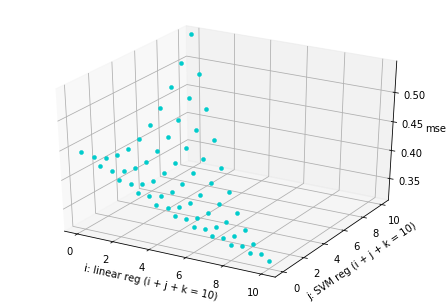

In [255]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("i: linear reg (i + j + k = 10)")
ax.set_ylabel("j: SVM reg (i + j + k = 10)")
ax.set_zlabel("mse")

ax.plot(ary[:, 1], ary[:, 2], ary[:, 3], "o", color="#00cccc", ms=4, mew=0.5)

In [400]:
#predictionの平均値
print("Linear Reg: ", (y_pred_lnr.reshape(1, -1)).mean())
print("SVR: ", (y_pred_svr.reshape(1, -1)).mean())
print("DT Reg: ", (y_pred_dtr.reshape(1, -1)).mean())

#正解データの平均値
print("Actual: ", (y_valid.reshape(1, -1)).mean())

Linear Reg:  0.05772065247738669
SVR:  -0.017109766441525565
DT Reg:  0.12246412133597512
Actual:  0.07642614547890125


## 【問題2】バギング
バギングを実装し、単一モデルより精度があがる例を最低1つ示してください。

バギングは入力データの選び方を多様化する方法です。学習データから重複を許した上でランダムに抜き出すことで、N種類のサブセット（ブートストラップサンプル）を作り出します。それらによってモデルをN個学習し、推定結果の平均をとります。ブレンディングと異なり、それぞれの重み付けを変えることはありません。

[sklearn.model_selection.train_test_split — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

scikit-learnのtrain_test_splitを、shuffleパラメータをTrueにして使うことで、ランダムにデータを分割することができます。これによりブートストラップサンプルが手に入ります。

推定結果の平均をとる部分はブースティングと同様の実装になります。

In [501]:
def pipeline(model, X, y, train_size = 8/10):
        #全サンプル数
        n_samples = X.shape[0]
        #train_test_split
        X_train, X_valid, y_train, y_valid = train_test(X, y, train_size)
        #scale
        X_train, X_valid, y_train, y_valid = scale(X_train, X_valid, y_train, y_valid)
        #fit, predict
        y_pred = fit_predict(model, X_train, X_valid, y_train)        
        return y_pred, y_valid

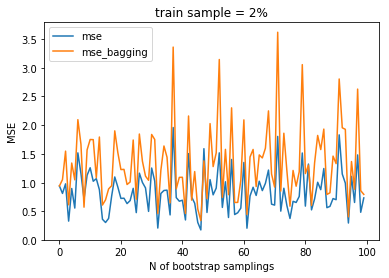

In [562]:
#インスタンス生成
lnr = LinearRegression()
svr = SVR()
dtr = DecisionTreeRegressor()

train_size = 2/100
#全サンプル数
n_samples = round(df.shape[0]*(1-train_size))
y_pred_rpt = np.empty((n_samples, 0))
#bootstrap sample & fit
mse_ary = np.empty((1, 0))
mse_bag_ary = np.empty((1, 0))
for i in range(100):
        y_pred, y_valid = pipeline(dtr, df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
        y_pred_rpt = np.append(y_pred_rpt, np.array(y_pred), axis=1)
        
        y_pred_bagging = y_pred_rpt.mean(axis=1)
        #evaluate
        mse = evaluate(y_valid, y_pred)
        mse_bag = evaluate(y_valid, y_pred_bagging)

        mse_ary = np.append(mse_ary, mse)
        mse_bag_ary = np.append(mse_bag_ary, mse_bag)

plt.plot(mse_ary, label='mse')
plt.plot(mse_bag_ary, label='mse_bagging')
plt.title('train sample = 2%')
plt.xlabel('N of bootstrap samplings')
plt.ylabel('MSE')
plt.legend()

[0.54888774]
[0.81082189]


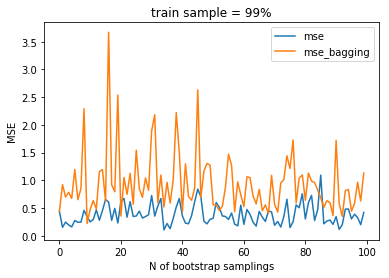

In [665]:
#インスタンス生成
lnr = LinearRegression()
svr = SVR()
dtr = DecisionTreeRegressor()

train_size = 99/100
#全サンプル数
n_samples = round(df.shape[0]*(1-train_size))
y_pred_rpt = np.empty((n_samples, 0))
#bootstrap sample & fit
mse_ary = np.empty((1, 0))
mse_bag_ary = np.empty((1, 0))
for i in range(100):
        y_pred, y_valid = pipeline(dtr, df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
        y_pred_rpt = np.append(y_pred_rpt, np.array(y_pred), axis=1)
        
        y_pred_bagging = y_pred_rpt.mean(axis=1)
        #evaluate
        mse = evaluate(y_valid, y_pred)
        mse_bag = evaluate(y_valid, y_pred_bagging)

        mse_ary = np.append(mse_ary, mse)
        mse_bag_ary = np.append(mse_bag_ary, mse_bag)

plt.plot(mse_ary, label='mse')
plt.plot(mse_bag_ary, label='mse_bagging')
plt.title('train sample = 99%')
plt.xlabel('N of bootstrap samplings')
plt.ylabel('MSE')
plt.legend()

#train_test_split
X_train, X_valid, y_train, y_valid = train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
#scale
X_train, X_valid, y_train, y_valid = scale(X_train, X_valid, y_train, y_valid)

y_pred = fit_predict(dtr, X_train, X_valid, y_train)
print(evaluate(y_valid, y_pred))
print(evaluate(y_valid,y_pred_bagging))

1168
[0.33889207]
[1.04661467]


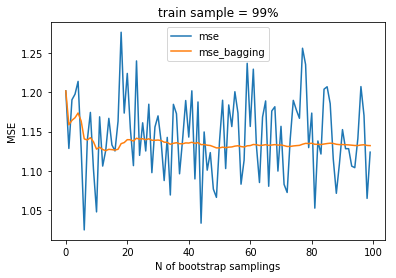

In [661]:
#インスタンス生成
lnr = LinearRegression()
svr = SVR()
dtr = DecisionTreeRegressor()

train_size = 80/100

#train_test_split
X_train, X_valid, y_train, y_valid = train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
#scale
X_train, X_valid, y_train, y_valid = scale(X_train, X_valid, y_train, y_valid)


#trainの全サンプル数
n_samples = X_train.shape[0]
y_pred_rpt = np.empty((X_valid.shape[0], 0))
print(n_samples)
#bootstrap sample & fit
mse_ary = np.empty((1, 0))
mse_bag_ary = np.empty((1, 0))
                                           
#bagging
for i in range(100):
        #重複を許してサンプリング
        rand_idx = np.random.randint(0, n_samples, size=n_samples)
        y_pred = fit_predict(svr, X_train[rand_idx, :], X_valid, y_train)      
        y_pred_rpt = np.append(y_pred_rpt, np.array(y_pred), axis=1)
        y_pred_bagging = y_pred_rpt.mean(axis=1)
        #evaluate
        mse = evaluate(y_valid, y_pred)
        mse_bag = evaluate(y_valid, y_pred_bagging)
        
        #loopごとのmseとmse_bagを保管
        mse_ary = np.append(mse_ary, mse)
        mse_bag_ary = np.append(mse_bag_ary, mse_bag)

plt.plot(mse_ary, label='mse')
plt.plot(mse_bag_ary, label='mse_bagging')
plt.title('train sample = 99%')
plt.xlabel('N of bootstrap samplings')
plt.ylabel('MSE')
plt.legend()

#train_test_split
X_train, X_valid, y_train, y_valid = train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
#scale
X_train, X_valid, y_train, y_valid = scale(X_train, X_valid, y_train, y_valid)

y_pred = fit_predict(svr, X_train, X_valid, y_train)
print(evaluate(y_valid, y_pred))
print(evaluate(y_valid,y_pred_bagging))

1168
[0.40174379]
[0.94550728]


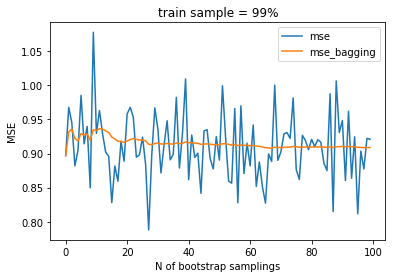

In [660]:
#インスタンス生成
lnr = LinearRegression()
svr = SVR()
dtr = DecisionTreeRegressor()

train_size = 80/100

#train_test_split
X_train, X_valid, y_train, y_valid = train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
#scale
X_train, X_valid, y_train, y_valid = scale(X_train, X_valid, y_train, y_valid)


#trainの全サンプル数
n_samples = X_train.shape[0]
y_pred_rpt = np.empty((X_valid.shape[0], 0))
print(n_samples)
#bootstrap sample & fit
mse_ary = np.empty((1, 0))
mse_bag_ary = np.empty((1, 0))
                                           
#bagging
for i in range(100):
        #重複を許してサンプリング
        rand_idx = np.random.randint(0, n_samples, size=n_samples)
        y_pred = fit_predict(lnr, X_train[rand_idx, :], X_valid, y_train)      
        y_pred_rpt = np.append(y_pred_rpt, np.array(y_pred), axis=1)
        y_pred_bagging = y_pred_rpt.mean(axis=1)
        #evaluate
        mse = evaluate(y_valid, y_pred)
        mse_bag = evaluate(y_valid, y_pred_bagging)
        
        #loopごとのmseとmse_bagを保管
        mse_ary = np.append(mse_ary, mse)
        mse_bag_ary = np.append(mse_bag_ary, mse_bag)

plt.plot(mse_ary, label='mse')
plt.plot(mse_bag_ary, label='mse_bagging')
plt.title('train sample = 99%')
plt.xlabel('N of bootstrap samplings')
plt.ylabel('MSE')
plt.legend()

#train_test_split
X_train, X_valid, y_train, y_valid = train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
#scale
X_train, X_valid, y_train, y_valid = scale(X_train, X_valid, y_train, y_valid)

y_pred = fit_predict(lnr, X_train, X_valid, y_train)
print(evaluate(y_valid, y_pred))
print(evaluate(y_valid,y_pred_bagging))

1168
[0.39223019]
[0.96725212]


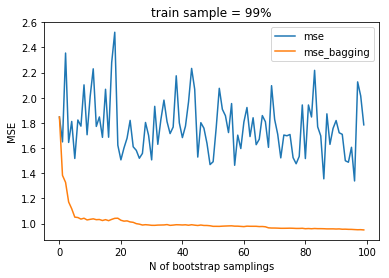

In [679]:
#インスタンス生成
lnr = LinearRegression()
svr = SVR()
dtr = DecisionTreeRegressor()

train_size = 80/100

#train_test_split
X_train, X_valid, y_train, y_valid = train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
#scale
X_train, X_valid, y_train, y_valid = scale(X_train, X_valid, y_train, y_valid)


#trainの全サンプル数
n_samples = X_train.shape[0]
y_pred_rpt = np.empty((X_valid.shape[0], 0))
print(n_samples)
#bootstrap sample & fit
mse_ary = np.empty((1, 0))
mse_bag_ary = np.empty((1, 0))
                                           
#bagging
for i in range(100):
        #重複を許してサンプリング
        rand_idx = np.random.randint(0, n_samples, size=n_samples)
        y_pred = fit_predict(dtr, X_train[rand_idx, :], X_valid, y_train)      
        y_pred_rpt = np.append(y_pred_rpt, np.array(y_pred), axis=1)
        y_pred_bagging = y_pred_rpt.mean(axis=1)
        #evaluate
        mse = evaluate(y_valid, y_pred)
        mse_bag = evaluate(y_valid, y_pred_bagging)
        
        #loopごとのmseとmse_bagを保管
        mse_ary = np.append(mse_ary, mse)
        mse_bag_ary = np.append(mse_bag_ary, mse_bag)

plt.plot(mse_ary, label='mse')
plt.plot(mse_bag_ary, label='mse_bagging')
plt.title('train sample = 99%')
plt.xlabel('N of bootstrap samplings')
plt.ylabel('MSE')
plt.legend()

#train_test_split
X_train, X_valid, y_train, y_valid = train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
#scale
X_train, X_valid, y_train, y_valid = scale(X_train, X_valid, y_train, y_valid)

y_pred = fit_predict(dtr, X_train, X_valid, y_train)
print(evaluate(y_valid, y_pred))
print(evaluate(y_valid,y_pred_bagging))

In [570]:
#重複あり
rand_idx = np.random.randint(0, n_samples, size=n_samples)
print(rand_idx)
value, count = np.unique(rand_idx, return_counts=True)
dict(zip(value, count))

[10  3  2 11  4  4  2  3  3  3 11 12  6  1 10]


{1: 1, 2: 2, 3: 4, 4: 2, 6: 1, 10: 2, 11: 2, 12: 1}

In [325]:
#重複なし
rand_idx_2= np.arange(0, n_samples)
print(rand_idx_2)
np.random.shuffle(rand_idx_2)
print(rand_idx_2)

value_2, count_2 = np.unique(rand_idx_2, return_counts=True)
dict(zip(value_2, count_2))

[   0    1    2 ... 1165 1166 1167]
[180 322 525 ... 790 543  53]


{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 1,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 1,
 79: 1,
 80: 1,
 81: 1,
 82: 1,
 83: 1,
 84: 1,
 85: 1,
 86: 1,
 87: 1,
 88: 1,
 89: 1,
 90: 1,
 91: 1,
 92: 1,
 93: 1,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 1,
 100: 1,
 101: 1,
 102: 1,
 103: 1,
 104: 1,
 105: 1,
 106: 1,
 107: 1,
 108: 1,
 109: 1,
 110: 1,
 111: 1,
 112: 1,
 113: 1,
 114: 1,
 115: 1,
 116: 1,
 117: 1,
 118: 1,
 119: 1,
 120: 1,
 121: 1,
 122: 1,
 12

[0.41552343]
[0.27053007]


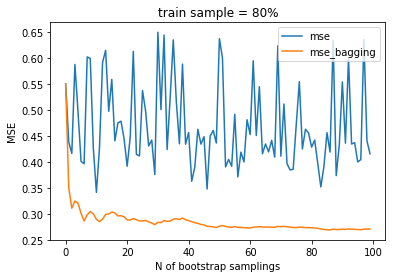

In [682]:
#インスタンス生成
lnr = LinearRegression()
svr = SVR()
dtr = DecisionTreeRegressor()

train_size = 80/100

#bootstrap sample & fit
mse_ary = np.empty((1, 0))
mse_bag_ary = np.empty((1, 0))

#train_test_split
X_train, X_valid, y_train, y_valid = train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
#scale
X_train, X_valid, y_train, y_valid = scale(X_train, X_valid, y_train, y_valid)


#bootstrap sample & fit
mse_ary = np.empty((1, 0))
mse_bag_ary = np.empty((1, 0))
for i in range(100):
        #重複を許してサンプリング
        rand_idx = np.random.randint(0, X_train.shape[0], size=X_train.shape[0])

        if (i == 0):
                y_pred_rpt = np.empty((y_valid.shape[0], 0))
        
        #fit, predict
        dtr = DecisionTreeRegressor()
        y_pred = fit_predict(dtr, X_train[rand_idx, :], X_valid, y_train[rand_idx])
        y_pred_rpt = np.append(y_pred_rpt, np.array(y_pred), axis=1)
        y_pred_bagging = y_pred_rpt.mean(axis=1)
        
        #evaluate
        mse = evaluate(y_valid, y_pred)
        mse_bag = evaluate(y_valid, y_pred_bagging)

        mse_ary = np.append(mse_ary, mse)
        mse_bag_ary = np.append(mse_bag_ary, mse_bag)

plt.plot(mse_ary, label='mse')
plt.plot(mse_bag_ary, label='mse_bagging')
plt.title('train sample = 80%')
plt.xlabel('N of bootstrap samplings')
plt.ylabel('MSE')
plt.legend()


y_pred = dtr.predict(X_valid)
print(evaluate(y_valid, y_pred))
print(evaluate(y_valid, y_pred_bagging))

## 【問題3】スタッキング
スタッキングを実装し、単一モデルより精度があがる例を最低1つ示してください。

スタッキングの手順は以下の通りです。最低限ステージ0とステージ1があればスタッキングは成立するため、それを実装してください。まずは
$K_0=3,M_0=2$程度にします。<br>


<br>学習時<br>
<br>ステージ 0<br>

学習データを$K_0$個に分割する。分割した内の ($K_0−1$)個をまとめて学習用データ、残1
個を推定用データとする組み合わせが $K_0$個作れる。<br>
あるモデルのインスタンスを$K_0$個用意し、異なる学習用データを使い学習する。<br>
それぞれの学習済みモデルに対して、使っていない残り1個の推定用データを入力し、推定値を得る（これをブレンドデータと呼ぶ）。<br>
さらに、異なるモデルのインスタンスも $K_0$個用意し、同様のことを行う。モデルが$M_0$個あれば、$M_0$個のブレンドデータが得られる。<br>

<br>ステージ$i$<br>

ステージ $i−1$のブレンドデータを$M_{i−1}$次元の特徴量を持つ学習用データと考え、 $K_i$個に分割する。以下同様である。<br>

<br>ステージ$N$＊最後のステージ<br>

ステージ $N−1$の $M_{N−1}$個のブレンドデータを $M_{N−1}$次元の特徴量の入力として、1種類のモデルの学習を行う。これが最終的な推定を行うモデルとなる。<br>

<br>推定時<br>
<br>ステージ 0<br>

テストデータを $K_{0}\times M_{0}$個の学習済みモデルに入力し、$K_{0}\times M_{0}$個の推定値を得る。これを $K_{0}$の軸で平均値を求め$M_{0}$ 次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）<br>

<br>ステージ$i$<br>

ステージ $i-1$で得たブレンドテストを$K_{i}\times M_{i}$個の学習済みモデルに入力し、$K_{i}\times M_{i}$個の推定値を得る。これを $K_{i}$ の軸で平均値を求め$M_{i}$次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）<br>

<br>ステージ $N$ ＊最後のステージ<br>

ステージ$N-1$で得たブレンドテストを学習済みモデルに入力し、推定値を得る。<br>

In [34]:
#数字をTrue, Falseのindexで取得する関数
def convert_index_to_bool_array(idx, size):
        bl =  np.zeros(size, dtype=bool)
        bl[idx] = True  
        return bl

In [35]:
#bool反転の関数
def get_reverse_bool(bool_to_reverse):
        return ((-1) * bool_to_reverse + 1).astype(bool) 

In [41]:
def generate_model_instance(model_name):
        if (model_name == 'linear_regression'):
                return LinearRegression()
        
        elif (model_name == 'decision_tree'):
                return DecisionTreeRegressor()

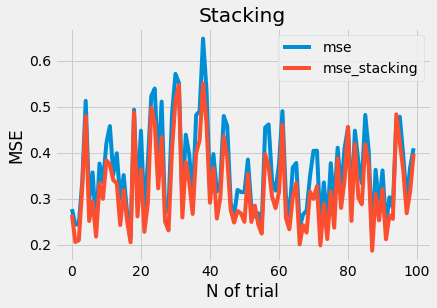

In [478]:
mse_rpt = np.empty((1, 0))
mse_stack_rpt = np.empty((1, 0))


train_size = 80/100


K_0 = 3
M_0 = 2
model_0 = ['linear_regression', 'decision_tree']

for _ in range(100):
        #train_test_split
        X_train, X_test, y_train, y_test= train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
        #scale
        X_train, X_test, y_train, y_test= scale(X_train, X_test, y_train, y_test)

        n_train_samples = X_train.shape[0]
        n_test_samples = X_test.shape[0]
        
        #学習
        #stage 0

        #Trainとvalidationデータのインデックス格納のための配列を初期化
        idx_train = np.empty((n_train_samples, 0))
        idx_valid = np.empty((n_train_samples, 0))

        for i in range(K_0):
                #validationデータのインデックスを生成
                idx = np.arange(round(n_train_samples * (i / K_0)), round(n_train_samples * ((i + 1) / K_0)))
                #数字の羅列を、対応するインデックスがTrueになった配列に変換
                idx = convert_index_to_bool_array(idx, n_train_samples).reshape(-1, 1)
                #ndarrayに格納
                idx_valid = np.append(idx_valid, idx, axis=1).astype(bool)

        #validationの反転がtrainデータ
        idx_train = get_reverse_bool(idx_valid)

        #モデルと予測値の格納先を初期化
        model_instance_stage_0 = [[] for j in range(K_0)]
        blend_data_stage_0 =  np.empty((n_train_samples, M_0))

        for i in range(M_0):
                for j in range(K_0):
                        #モデルのインスタンスを生成して格納
                        model_instance_stage_0[i].append(generate_model_instance(model_0[i]))                
                        #fit & predictして
                        pred = fit_predict(model_instance_stage_0[i][j], X_train[idx_train[:, j]], X_train[idx_valid[:, j]], y_train[idx_train[:, j]]).reshape(-1,)
                        #prediction dataをblendして新たなfeatureに
                        blend_data_stage_0[idx_valid[:, j], i] =  pred

        #stage k

        #stage N( N=1)
        model_instance_stage_n = LinearRegression()
        blend_data_stage_n  = fit_predict(model_instance_stage_n, blend_data_stage_0, X_test, y_train).reshape(-1,)

        #推定
        #stage 0

        #blend testの格納先を初期化
        blend_test_stage_0 =  np.empty((n_test_samples, M_0))
        for i in range(M_0):
                #予測値の格納先を初期化
                pred = np.empty((n_test_samples, 0))
                for j in range(K_0):
                        #stage0の学習済みモデルにvalid dataを入れてpredict
                        pred = np.append(pred, model_instance_stage_0[i][j].predict(X_test).reshape(-1, 1), axis=1)
                #分割数方向に平均をとって、shape(n_test_samples, model数)のブレンドテストを生成
                blend_test_stage_0[:, i] =  np.mean(pred, axis=1)

        #stage k

        #stage N( N=1)
        prediction = model_instance_stage_n.predict(blend_test_stage_0)

        #----------------------------------

        lnr = LinearRegression()
        y_pred = fit_predict(lnr, X_train, X_test, y_train).reshape(-1, 1)

        mse_rpt = np.append(mse_rpt, evaluate(y_test, y_pred))
        mse_stack_rpt = np.append(mse_stack_rpt, evaluate(y_test, prediction))


#plot
plt.style.use('fivethirtyeight')
plt.plot(mse_rpt, label='mse')
plt.plot(mse_stack_rpt, label='mse_stacking')
plt.title('Stacking')
plt.xlabel('N of trial')
plt.ylabel('MSE')
plt.legend()

plt.show()

### ステージ数とK, Mの数を一般化してクラス化

In [618]:
import numpy as np

#学習モデルをインポート
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

class StackingLayer():
        """
        Note
        --------------------------------
        stackingにおける各stageのクラス
        各ステージにおけるlearnとestimateを担う

        Parameters, Attributes
        --------------------------------
        max_stage: int
            最後のステージ（Layer）。再帰を止めるために用意
        stage: int
            現在のステージ（Layer）。再帰を止めるために用意
        n_train_samples: int
            分割前のtrainサンプルのサイズ
        K: int
            そのステージにおけるtrainデータの分割数
        M: int
            そのステージにおけるモデルの数（種類数）
        model_instance：nparray shape(M, K)
            modelのインスタンスを格納
        nxt_layer: StackingLayerクラスのインスタンス
            一つ後のLayer（ステージ）。再帰的に呼ぶために用意
        """
        def __init__(self, max_stage, stage):
                self.max_stage = max_stage
                self.stage  = stage
                self.n_train_samples = None 
                self.K = None
                self.M = None
                self.model_instance = None
                self.nxt_layer = None
        
        #学習時
        def learn(self, split_list, model_list, feat_train, target_train, ):
                #サンプル数を記録
                self.K = len(split_list)
                self.M = len(model_list[self.stage])
                self.n_train_samples = target_train.shape[0]
                """
                Split array
                """
                #indexを生成
                idx_train, idx_valid = self._gen_split_index()
                
                """
                fit & pred to generate blend data
                """
                #blend_dataを空で初期化
                blend_data =  np.empty((self.n_train_samples, self.M), dtype='float64')
                #モデルのインスタンスの格納先を空で初期化
                self.model_instance = np.empty((self.M, self.K), dtype='object')
                
                #モデル数に対してループ
                for i in range(self.M):
                        #分割数に対してループ
                        for j in range(self.K):
                                #モデルのインスタンスを生成して格納
                                self.model_instance[i, j] = self._gen_model_instance(model_list[self.stage][i])            
                                #fit & predict
                                #train側に分けたfeatureとtargetデータでfit
                                self.model_instance[i, j].fit(feat_train[idx_train[:, j]], target_train[idx_train[:, j]])
                                #valid側に分けたfeatureデータでpredict
                                pred = self.model_instance[i, j].predict(feat_train[idx_valid[:, j]]).reshape(-1,)
                                
                                #prediction dataをblend
                                #k=Nの時は要らないのでスキップ
                                if (self.stage != self.max_stage): 
                                        blend_data[idx_valid[:, j], i] =  pred
                """
                Next Stage
                """
                #k=Nになるまで再帰させる
                
                #stageがk = Nなら
                if (self.stage == self.max_stage):
                        #再帰終了
                        return 
                
                #stage 0 to N-1の時
                #next_layerのインスタンス生成
                self.nxt_layer = StackingLayer(
                        max_stage=self.max_stage,
                        stage=self.stage + 1
                )
                
                #子のステージの学習
                self.nxt_layer.learn(split_list=split_list, model_list=model_list,  feat_train=blend_data, target_train=target_train)
                return
        
        #推定時
        def estimate(self, feat_test):
                n_test_samples = feat_test.shape[0]

                #stage Nの時
                if (self.stage == self.max_stage):
                        #予測値を返却して再帰終了
                        return self.model_instance[0, 0].predict(feat_test)
                #stage 0 to N-1の時                
                """
                predict with learned model
                """
                #blend testの格納先を初期化
                blend_test =  np.empty((n_test_samples, self.M), dtype='float64')
                
                for i in range(self.M):
                        #各モデルによるpredの一時的保管のために用意
                        pred = np.empty((n_test_samples, 0), dtype='float64')
                        for j in range(self.K):
                                pred = np.append(pred, self.model_instance[i][j].predict(feat_test).reshape(-1, 1), axis=1)
                         #分割数方向に平均をとって、shape(n_test_samples, model数)のブレンドテストを生成
                        blend_test[:, i] =  np.mean(pred, axis=1)
                """
                Next Stage
                """
                #k=Nになるまで再帰
                return self.nxt_layer.estimate(blend_test)
        
        def _gen_split_index(self):
                #Trainとvalidationデータのインデックス格納のための配列を初期化
                idx_valid = np.empty((self.n_train_samples, 0), dtype='bool')
                
                #ランダムなインデックスを生成
                rand_idx= np.arange(0, self.n_train_samples)
                np.random.shuffle(rand_idx)

                for i in range(self.K):
                        #validationデータのインデックスを生成
                        idx = rand_idx[round(self.n_train_samples * (i / self.K)):round(self.n_train_samples * ((i + 1) / self.K))]
                        #数字の羅列を、対応するインデックスがTrueになった配列に変換
                        idx = self._convert_index_to_bool_array(idx, self.n_train_samples).reshape(-1, 1)
                        #ndarrayに格納
                        idx_valid = np.append(idx_valid, idx, axis=1).astype(bool)

                #validationのbool反転がtrainデータに対応
                idx_train =  ((-1) * idx_valid + 1).astype(bool)
                
                #K=1の場合（分割しない場合)
                if (self.K == 1):
                        #idx_trainが全てFalse、idx_validが全てTrueとなってしまい学習できないので、両者とも全てTrue
                        idx_train = idx_valid
                return idx_train, idx_valid
                
        def _convert_index_to_bool_array(self, idx, size):
                #数字をTrue, Falseのindexで取得する関数
                bl =  np.zeros(size, dtype=bool)
                bl[idx] = True  
                return bl
        
        def _gen_model_instance(self, model_name):
                if (model_name == 'lnr'):
                        return LinearRegression()
                elif (model_name == 'dtr'):
                        return DecisionTreeRegressor()
                elif (model_name == 'svr'):
                        return SVR()
                
class ScratchStacking():
        """
        Note
        --------------------------------
        stackingにおける全stageのまとまりを表現したクラス

        Parameters, Attributes
        --------------------------------
        split_list: list shape(n of stages,)
            各ステージにおける
        model_list: list shape(n of models, )
            各ステージにおいて使うモデルのリスト
        n_stage: int
            全ステージ数
        root: object
            ステージ0のStackingLayer
        """
        def __init__(self):
                self.n_stages = len(split_list)
                self.root = None

        def fit(self, split_list, model_list, feat_train, target_train): 
                #データ整形
                feat_train = np.array(feat_train)
                target_train = np.array(target_train).reshape(-1, 1)
                
                #stage 0のインスタンスを生成
                self.root = StackingLayer(
                                max_stage=self.n_stages - 1,
                                stage=0
                            )
                #学習
                self.root.learn(
                    split_list=split_list, model_list=model_list, feat_train=feat_train, target_train=target_train)
                #返却値なし
                return
        
        def predict(self, feat_test):
                #データ整形
                feat_test = np.array(feat_test)
                #推定
                pred = self.root.estimate(feat_test)
                return pred
        
        def evaluate(self, target_test, pred):
                #データ整形
                target_test = np.array(target_test).reshape(-1, 1)
                #MSE算出
                mse = ((target_test - pred).T @ (target_test - pred)/len(target_test))[0][0]
                return mse

In [624]:

split_list = [3, 5, 4, 2, 1]#各ステージにおける分割数Kのリスト
model_list = [
    ['lnr', 'dtr'],
    ['lnr', 'dtr'],
    ['lnr'],
    ['lnr', 'dtr', 'svr'],
    ['lnr']
]

stack = ScratchStacking()
stack.fit(split_list, model_list, X_train, y_train)
pred = stack.predict(X_test)
mse = stack.evaluate(y_test, pred)
print("mse: ", mse)


mse:  0.27379653800087744


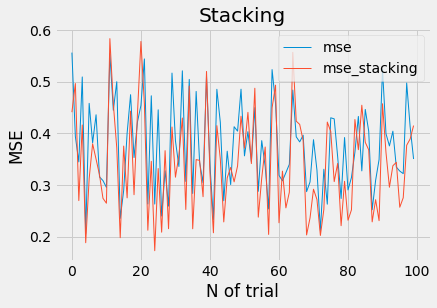

In [628]:
split_list = [3, 5, 4, 2, 1]#各ステージにおける分割数Kのリスト
model_list = [
    ['lnr', 'dtr'],
    ['lnr', 'dtr'],
    ['lnr'],
    ['lnr', 'dtr', 'svr'],
    ['lnr']
]#各ステージにおけるモデルのリスト

mse_rpt = np.empty((1, 0))
mse_stack_rpt = np.empty((1, 0))

for _ in range(100):
        #train_test_split
        X_train, X_test, y_train, y_test= train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
        #scale
        X_train, X_test, y_train, y_test= scale(X_train, X_test, y_train, y_test)
        #通常のfit & predict
        lnr = LinearRegression()
        y_pred = fit_predict(lnr, X_train, X_test, y_train).reshape(-1, 1)
        mse_rpt = np.append(mse_rpt, evaluate(y_test, y_pred))
        
        #stacking
        stack = ScratchStacking()
        stack.fit(split_list, model_list, X_train, y_train)
        stack_pred = stack.predict(X_test)
        stack_mse = stack.evaluate(y_test, stack_pred)

        mse_stack_rpt = np.append(mse_stack_rpt, stack_mse)
#plot
plt.style.use('fivethirtyeight')
plt.plot(mse_rpt, label='mse', linewidth = 1.0)
plt.plot(mse_stack_rpt, label='mse_stacking', linewidth = 1.0)
plt.title('Stacking')
plt.xlabel('N of trial')
plt.ylabel('MSE')
plt.legend()

plt.show()

In [ ]:
大体の試行回において、stackingしている方がMSEが小さくなった。
stackingの効果を確かめられた。

## 【問題4】（アドバンス課題）Microsoft Malware Prediction
時間的に余裕がある場合は、KaggleのMalwareコンペを題材に、アンサンブル学習を実際に利用してみましょう。EDAからはじめ、推定値の提出まで挑戦してください。

[Microsoft Malware Prediction | Kaggle](https://www.kaggle.com/c/microsoft-malware-prediction)
です。